Use the final csv files for train and test and use various models to train and score them

# 1. Import and Load

In [1]:
import pandas as pd
import numpy as np

# models
from sklearn.ensemble import RandomForestRegressor
# uncomment to install the three models below >>>>>
# !pip3 install catboost
# !pip install lightgbm
# !pip3 install xgboost
# <<<<<<<<<<<<<<<<<<<<<<<<
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# processing
from sklearn.model_selection import train_test_split

# parameters search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


# scoring
import math
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

# explain
import shap

In [2]:
TRAIN_PATH = "../Data/microclimate_model/Combined/three_bldgs_dropped.csv"
TEST_PATH = "../Data/microclimate_model/Combined/three_bldgs_J9_dropped.csv"


# 2. Data Class

In [3]:

"""
This class encapsulates the datas that we will need for training and testing.
It only contains getters for the train and test data
"""
class Data(object):
    def __init__(self, train_path, test_path):
        """
        Parameters:
            train_path (str) : The file path for the trainning csv file. 
            test_path (str) : The path for the test csv file. 
        
        Both train and test datas have 16 columns with buildings already encoded
        """
        dropped_cols = ['CHWTON/SQM', "bldgname_ISTB 4"]
        # - Train and validation data
        self.train_val_df = pd.read_csv(train_path, index_col=0)
        self.X_train_val = self.train_val_df.drop(columns=dropped_cols)
        self.y_train_val = self.train_val_df['CHWTON/SQM']  
        
        # - Test data
        self.test_df = pd.read_csv(test_path, index_col=0)
        self.X_test = self.test_df.drop(columns=dropped_cols)
        self.y_test = self.test_df['CHWTON/SQM'] 
        
    
    def get_xy_trainval(self):
        """
        Return the X and y for training data which we can split to train and validation data later.
        """
        return self.X_train_val, self.y_train_val
    
    def get_xy_test(self):
        """
        Return the X and y for June 9th test data
        """
        return self.X_test, self.y_test
        

# 3. Explainer Class

In [4]:
"""
This class contains X_test datas that will be used to plot the explainer.
It will plot the explainer using shap library. make sure Shap is already imported
"""
class Explainer(object):
    
    def __init__(self, X_test):
        self.X_test = X_test
        
        # fig index
        self.fig_id = 0
        
        
    def plot(self, model, model_name):
        # 1. init explainer
        explainer = shap.TreeExplainer(
            model=model,
            data=None,
            model_output='raw',
            feature_perturbation='tree_path_dependent'
        )
        
        # 2. get shap values from explainer
        shap_values = explainer.shap_values(self.X_test)
        
        # 3. single sample plot
        # shap.initjs()
        # i = 7
        # shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], matplotlib = True)
        # plt.title(model_name)

        # 4. summary plot
        plt.figure(self.fig_id)
        
        # increment fig index for next plot
        self.fig_id += 1
        
        shap.summary_plot(shap_values, self.X_test, plot_size = [8,6], show = False)
        plt.title(model_name)
        plt.gcf().axes[-1].set_aspect(10)
        plt.gcf().axes[-1].set_box_aspect(10)

# 4. Train Test Class

In [5]:
"""
This class encapsulates the the training and testing process.
It stores the train and test datas that's already split to X and y
"""
class TrainTest(object):
    def __init__(self, X_train_val, y_train_val, X_test, y_test):
        # - scores_df to display the scores for all our models
        self.columns=['model','r2_val', 'r2_test', 'rmse_test','mbe_test']
        self.scores_df= pd.DataFrame(columns=self.columns)
        
        # - train and test data
        self.X_train_val = X_train_val
        self.y_train_val = y_train_val
        self.X_test = X_test
        self.y_test = y_test
        
        self.explainerObj = Explainer(self.X_test)
    
    def get_scores_df(self):
        return self.scores_df
    
    
    def train_and_store_score(self, model, model_name):
        """
        This function will train the model given as parameter using the training data. It will compute the r2 validation score
        and append this as a new row to scores_df.
        
        Parameters:
            model (regressor model) : The model object that will be trained and used in validation.
                It can be RF, XGB, LGBM, or catboost regressor
                
            model_name (str) : the name of the model displayed in scores_df
            
        RetursnL
            model : this is relevant if we are doing randomized search. it will return the best model
        """
        # 1. Train-Val Split
        X_train, X_val, y_train, y_val = train_test_split(self.X_train_val, 
                                                          self.y_train_val, 
                                                          test_size=0.3, 
                                                          random_state=20)

        # 2. fit model that already has parameters
        model.fit(X_train, y_train)


        # - Get best params if it's a random or grid search
        if("random" in model_name) or ("grid" in model_name):
            # print(model.best_estimator_.get_params())
            model = model.best_estimator_
            
        
        
        # 3. get validation R2 score
        val_r2 = model.score(X_val, y_val)
        
        # 4. store score
        new_row_data = {'model':model_name, "r2_val":val_r2, "r2_test":0, 'rmse_test':0, 'mbe_test':0}
        new_row = pd.DataFrame.from_records([new_row_data])
        self.scores_df = pd.concat([self.scores_df, new_row])
        
        return model
    
    def get_MBE(self, y_true, y_pred):
        '''
        Parameters:
            y_true (array): Array of observed values
            y_pred (array): Array of prediction values

        Returns:
            mbe (float): Bias score
        '''
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_true = y_true.reshape(len(y_true),1)
        y_pred = y_pred.reshape(len(y_pred),1)   
        diff = (y_pred-y_true)
        mbe = diff.mean()
        return mbe

        
    def test_and_store_score(self, model, model_name):
        """
        This function will use the given trained model to compute the y_pred using the X_test data.
        It will then compute the mbe, r2, and rmse result and insert it to scores_df. 
        
        Parameters:
            model (regressor model): The model that has been trained and will be used to predict y using the test data
                It can be RF, XGB, LGBM, or catboost regressor
            model_name (string): the name of the model displayed in scores_df
        
        """
        # 1. Get prediction for the test data
        y_pred = model.predict(self.X_test)
        
        # 2. get the three scores
        r2 = r2_score(self.y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(self.y_test, y_pred))
        mbe = self.get_MBE(self.y_test, y_pred)
        
        # 3. update scores_df with the 3 scores above
        row_to_update = self.scores_df["model"] == model_name
        col_to_update = ['r2_test','rmse_test', 'mbe_test']
        self.scores_df.loc[row_to_update, col_to_update] = [r2, rmse, mbe]
        
        # print("r2:", r2)
        # print("rmse:", rmse)
        # print("mbe:", mbe)
        
    def train_test_plot_models(self, model_list):
        for model_name, model in model_list:
            
            # - need to do this in case its randomized search
            best_model = self.train_and_store_score(model, model_name)
            self.test_and_store_score(best_model, model_name)
            self.explainerObj.plot(best_model, model_name)

# 4. Random Forest Class

In [12]:
from abc import ABC, abstractmethod
class Model():

    @abstractmethod
    def get_base_model(self):
        return self.base_name, self.base
    
    @abstractmethod
    def get_random_model(self):
        return self.random_name, self.random

In [13]:
"""
This class contains the Random forest base model and the tuned model using randomized search cv.
"""
class RandomForest(Model):
    def __init__(self):
        
        # A. base model
        self.base_name = "rf_base"
        self.base = RandomForestRegressor(n_estimators = 100, random_state = 42)
        
        
        # B. Randomized tuned model 
        # 1. Number of trees in random forest
        # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
        n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

        # 2. Maximum number of levels in tree
        # [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)

        # 3. Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]

        # 4. Minimum number of samples required at each leaf node
        min_samples_leaf = [ 1, 2, 4]

        # 5. Method of selecting samples for training each tree
        bootstrap = [True]

        # 6. Number of features to consider at every split
        max_features = ["sqrt", "log2", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        
        # 7.
        criterion = ['squared_error', 'absolute_error', 'poisson']
        
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'criterion': criterion,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
        
# [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
        self.random_name = "rf_random"
        self.random = RandomizedSearchCV(
                            estimator = self.base,
                            param_distributions = random_grid,
                            n_iter = 20,
                            cv = 5,
                            verbose = 2,
                            scoring ='r2',
                            random_state = 42,
                            n_jobs = -1)
        
    
    

        
        

# 5. XGB class

In [14]:
"""
This class contains the XGB base model and the tuned model using randomized search cv.
It only contain getters that return the model and the model name for each of the models
"""
class XGB(Model):
    def __init__(self):
        
        # A. base model
        self.base_name = "xgb_base"
        self.base = XGBRegressor(n_estimators = 100, random_state = 42)
        
        
        # B. Randomized tuned model 
        random_grid = {
            'learning_rate' : [0.1, 0,2 ,0.3, 0.4],
            'n_estimators':[ 100, 250, 500, 1000],
            'min_child_weight':[1, 2, 4, 5, 8], 
            'max_depth': [4,6,7,8],
            'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7, 1 ],
            'booster': ['gbtree', 'gblinear']
        }
        
        self.random_name = "xgb_random"
        self.random = RandomizedSearchCV(
                            estimator = self.base,
                            param_distributions = random_grid,
                            n_iter = 20,
                            cv = 5,
                            verbose = 0,
                            scoring ='r2',
                            random_state = 42,
                            n_jobs = -1)
        

In [15]:
"""
This class contains the XGB base model and the tuned model using randomized search cv.
It only contain getters that return the model and the model name for each of the models
"""
class LGBM(Model):
    def __init__(self):
        
        # A. base model
        self.base_name = "lgbm_base"
        self.base = LGBMRegressor(random_state = 42)
        
        # B. Randomized tuned model 
        random_grid = {
                'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
                'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
                'num_leaves': [10,15,20,30,40], 
                'min_child_samples': [10,20,40,50,100],
                'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                'subsample': [0.1, 0.3, 0.8, 1.0], 
                'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
                'colsample_bytree': [0.4, 0.5, 0.6, 1.0],
                'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
        
        self.random_name = "lgbm_random"
        self.random = RandomizedSearchCV(
                            estimator = self.base,
                            param_distributions = random_grid,
                            n_iter = 20,
                            cv = 5,
                            verbose = 0,
                            scoring ='r2',
                            random_state = 42,
                            n_jobs = -1)
        
        
        # {'boosting_type': 'gbdt',
        #  'class_weight': None, 
        #  'colsample_bytree': 1.0,
        #  'importance_type': 'split', 
        #  'learning_rate': 0.1,
        #  'max_depth': -1,
        #  'min_child_samples': 20, 
        #  'min_child_weight': 0.001, 
        #  'min_split_gain': 0.0,
        #  'n_estimators': 100,
        #  'n_jobs': -1,
        #  'num_leaves': 31,
        #  'objective': None, 
        #  'random_state': 42,
        #  'reg_alpha': 0.0, 
        #  'reg_lambda': 0.0, 
        #  'silent': 'warn',
        #  'subsample': 1.0, 
        #  'subsample_for_bin': 200000, 
        #  'subsample_freq': 0}


# 7. Catboost Class

In [16]:
"""
This class contains the Catboost base model and the tuned model using randomized search cv.
It only contain getters that return the model and the model name for each of the models
"""
class Catboost(Model):
    def __init__(self):
        
        # A. base model
        self.base_name = "catboost_base"
        self.base = CatBoostRegressor(random_state = 42, verbose=False)
        
        
        # B. Randomized tuned model 
        random_grid = {
                'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
                'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000],
                'depth': [4, 6, 10],
                'l2_leaf_reg': [1, 3, 5, 7, 9]}
        
        self.random_name = "catboost_random"
        self.random = RandomizedSearchCV(
                            estimator = self.base,
                            param_distributions = random_grid,
                            n_iter = 20,
                            cv = 5,
                            verbose = 0,
                            scoring ='r2',
                            random_state = 42,
                            n_jobs = -1)

In [17]:
def main():
    # 1. get train_val and test datas
    data_obj = Data(TRAIN_PATH, TEST_PATH)
    X_train_val, y_train_val = data_obj.get_xy_trainval()
    X_test, y_test = data_obj.get_xy_test()

    # 2. init the trainTest object and insert datas
    tt = TrainTest(X_train_val, y_train_val,X_test, y_test)


    # 3. init model object
    rf = RandomForest()
    xgb = XGB()
    lgbm = LGBM()
    catboost = Catboost()

    # 4. append all base and random version of each models
    model_objects = [rf, xgb, lgbm, catboost]
    all_base_random = []

    for model in model_objects:
        base_name, base_model = model.get_base_model()
        random_name, random_model = model.get_random_model()
        all_base_random.extend([(base_name, base_model), (random_name, random_model)])


    # 5. train, test, shap all models
    tt.train_test_plot_models(all_base_random)
    scores_df = tt.get_scores_df()
    print(scores_df)
    
    

Fitting 5 folds for each of 20 candidates, totalling 100 fits


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


             model    r2_val   r2_test rmse_test  mbe_test
0          rf_base   0.98629  0.968016  0.001607  0.000829
0        rf_random  0.986907  0.982542  0.001187  0.000288
0         xgb_base  0.984482  0.980005  0.001271  0.000668
0       xgb_random  0.985062  0.980735  0.001247  0.000482
0        lgbm_base  0.985652  0.975189  0.001415  0.000737
0      lgbm_random   0.98456  0.980503  0.001255  0.000442
0    catboost_base  0.987611  0.982706  0.001182  0.000506
0  catboost_random  0.987523  0.985304  0.001089   0.00035


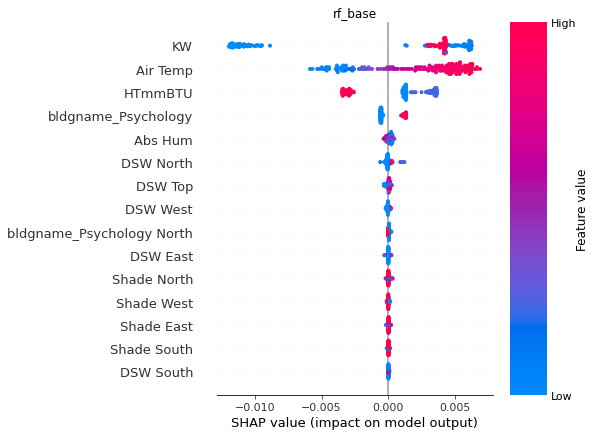

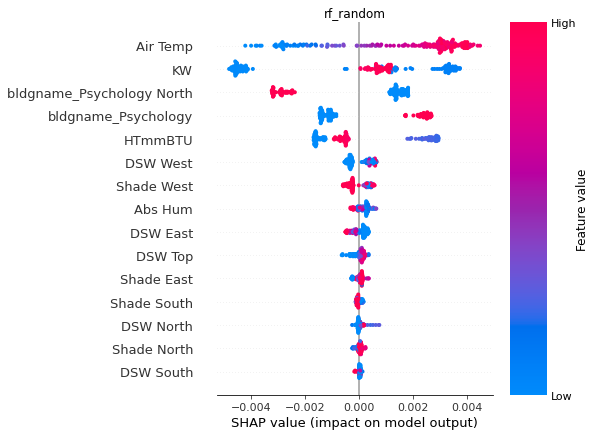

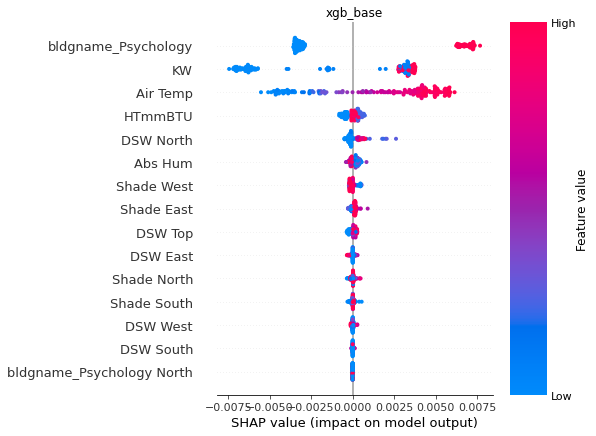

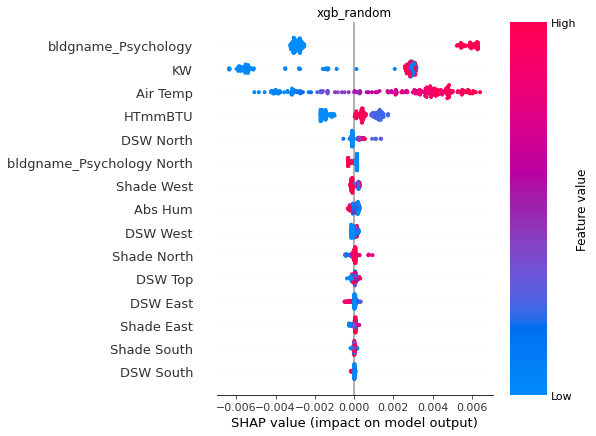

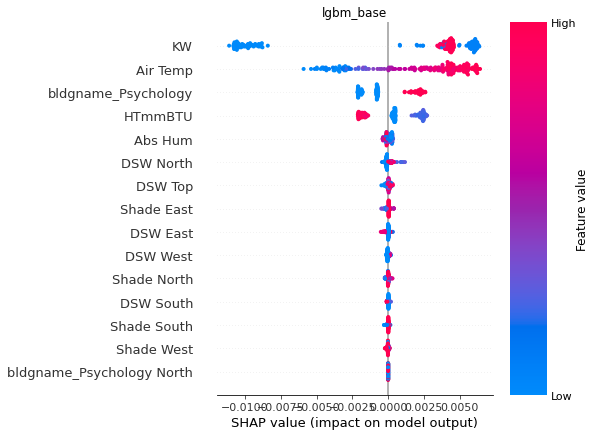

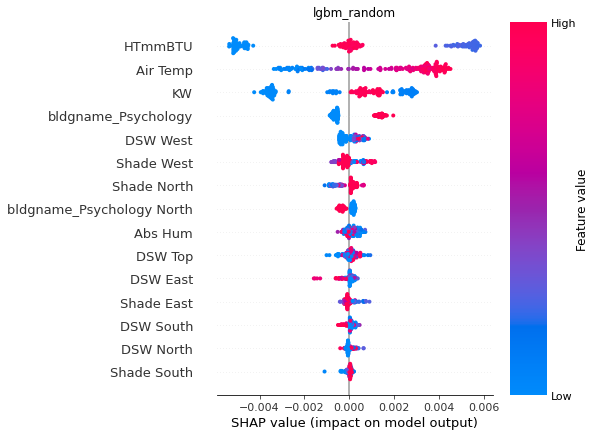

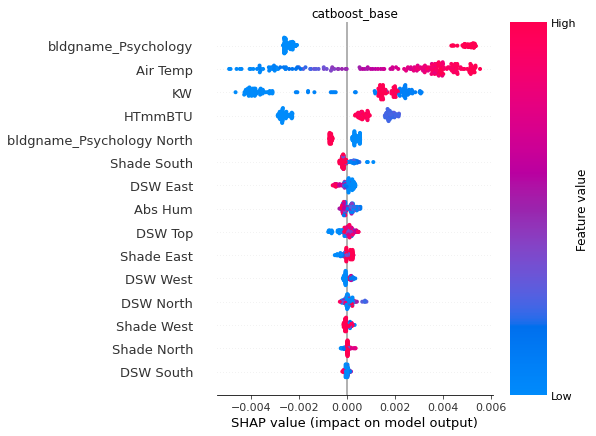

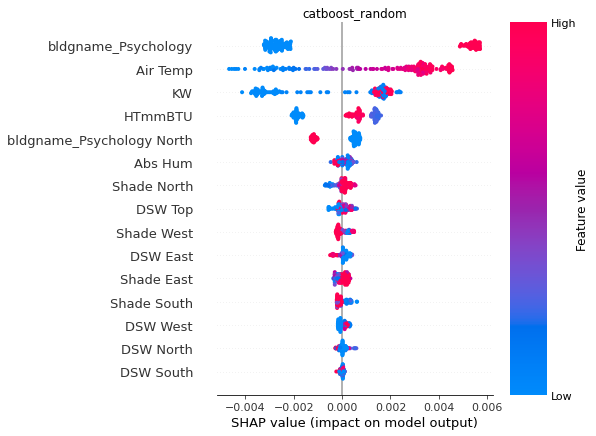

In [18]:
if __name__ == "__main__":
    main()

## Note:
1. drop istb_4 column since its redundant. increased the RF test result.
2. changed the radnomised search cv for RF. now the result is quite good
3. 

# 5. Model Class

In [6]:
class Model():
    def __init__(self, name, base_model, random_grid):
        self.base_name = name + "_base"
        self.base = base_model
        
        
        self.random_name = name + "_random"
        self.random = RandomizedSearchCV(
                            estimator = self.base,
                            param_distributions = random_grid,
                            n_iter = 20,
                            cv = 5,
                            verbose = 0,
                            scoring ='r2',
                            random_state = 42,
                            n_jobs = -1)
    
    def get_base_model(self):
        return self.base
    
    
    def get_random_model(self):
        return self.random
    
    def get_base_name(self):
        return self.base_name
    
    
    def get_random_name(self):
        return self.random_name

In [7]:
# RF
# A. base model
rf_name = "rf"
rf_base = RandomForestRegressor(n_estimators = 100, random_state = 42)

# B. grid for random model
rf_random_grid = {
                # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
                'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)],
                'max_features': ["sqrt", "log2", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
                'criterion': ['squared_error', 'absolute_error', 'poisson'],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [ 1, 2, 4],
                'bootstrap': [True] }

In [8]:
# XGB
xgb_name = "xgb"
xgb_base = XGBRegressor(n_estimators = 100, random_state = 42)

xgb_random_grid = {
    'learning_rate' : [0.1, 0,2 ,0.3, 0.4],
    'n_estimators':[ 100, 250, 500, 1000],
    'min_child_weight':[1, 2, 4, 5, 8], 
    'max_depth': [4,6,7,8],
    'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7, 1 ],
    'booster': ['gbtree', 'gblinear'] }

In [9]:
# LGBM
# A. base model
lgbm_name = "lgbm"
lgbm_base = LGBMRegressor(random_state = 42)

# B. grid for random model
lgbm_random_grid = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
                'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
                'num_leaves': [10,15,20,30,40], 
                'min_child_samples': [10,20,40,50,100],
                'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                'subsample': [0.1, 0.3, 0.8, 1.0], 
                'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
                'colsample_bytree': [0.4, 0.5, 0.6, 1.0],
                'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [10]:
# CATBOOST
# A. base model
catboost_name = "catboost"
catboost_base = CatBoostRegressor(random_state = 42, verbose=False)


# B. Randomized tuned model 
catboost_random_grid = {
        'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
        'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


[20:56:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not used.

[20:56:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[20:56:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not used.

[20:56:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_threshold", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } are not

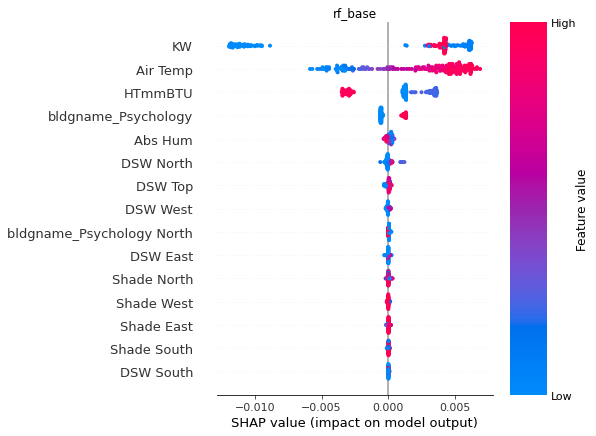

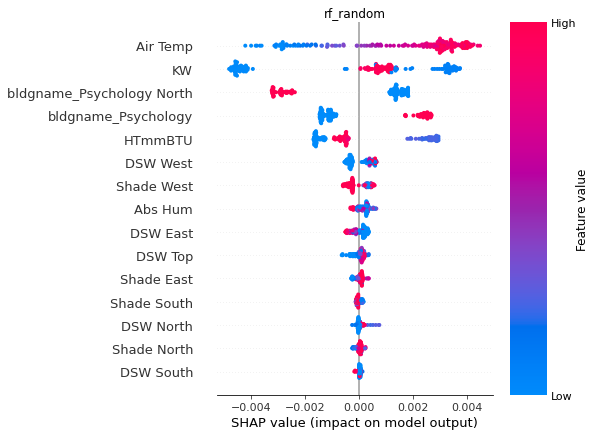

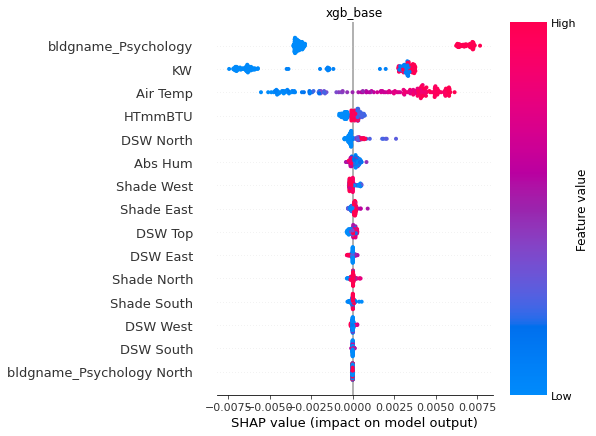

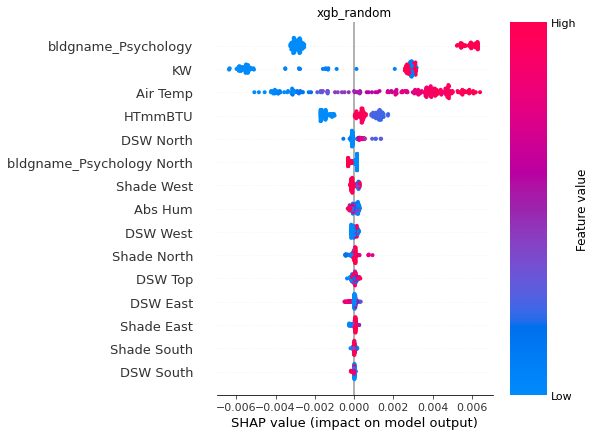

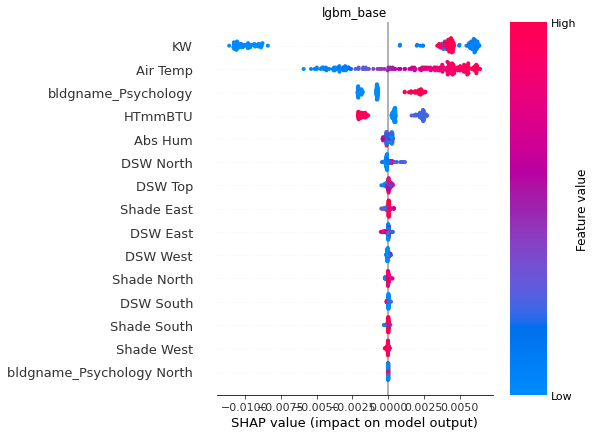

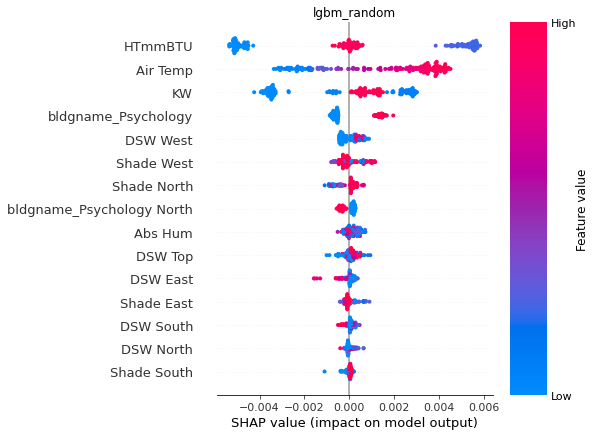

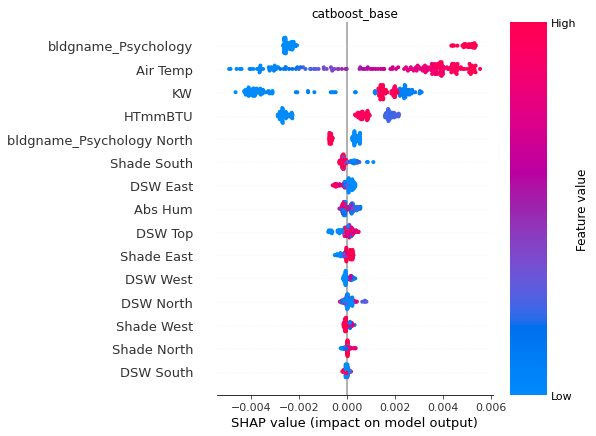

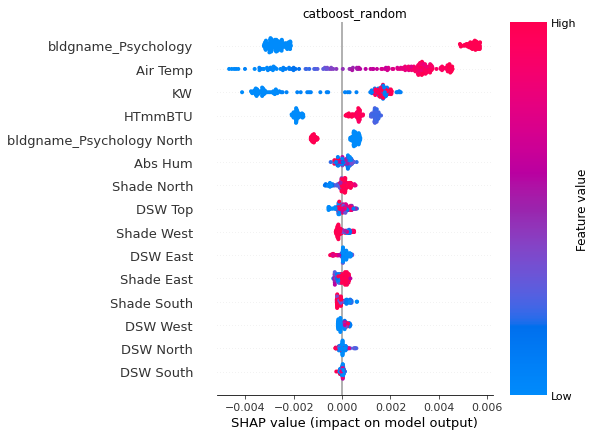

In [11]:
# 1. get train_val and test datas
data_obj = Data(TRAIN_PATH, TEST_PATH)
X_train_val, y_train_val = data_obj.get_xy_trainval()
X_test, y_test = data_obj.get_xy_test()

# 2. init the trainTest object and insert datas
tt = TrainTest(X_train_val, y_train_val,X_test, y_test)


# 3. init model object
rf = Model(rf_name, rf_base, rf_random_grid)
xgb = Model(xgb_name, xgb_base, xgb_random_grid)
lgbm = Model(lgbm_name, lgbm_base, lgbm_random_grid)
catboost = Model(catboost_name, catboost_base, catboost_random_grid)

# 4. append all base and random version of each models
model_objects = [rf, xgb, lgbm, catboost]
all_base_random = []

for model in model_objects:
    base_name, base_model = model.get_base_name(), model.get_base_model()
    random_name, random_model = model.get_random_name(), model.get_random_model()
    all_base_random.extend([(base_name, base_model), (random_name, random_model)])


# 5. train, test, shap all models
tt.train_test_plot_models(all_base_random)
scores_df = tt.get_scores_df()
print(scores_df)